In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import re

In [2]:
#Load dataset
digi = pd.read_csv("Transactions.csv", encoding = 'latin-1')
digi.head(2)

,CompletionTime,InitiationTime,TransactionDetails,PaidIn,OtherPartyInfo,County,CountyCode
0,1/9/2021,1/9/2021 10:52,Pay Bill from 0768788662 - PETRO NYAGOTERIA MO...,10650.0,0768788662 - PETRO NYAGOTERIA MOGAYA,Migori,44
1,1/9/2021,1/9/2021 17:08,Pay Bill from 254717363640 - KIRUI ISAAC Acc. ...,1590.0,254717363640 - KIRUI ISAAC,Kericho,35


In [3]:
digi = digi[['CompletionTime', 'PaidIn', 'OtherPartyInfo', 'County']]
digi.dropna(axis = 0, inplace = True)

In [4]:
digi.head()

,CompletionTime,PaidIn,OtherPartyInfo,County
0,1/9/2021,10650.0,0768788662 - PETRO NYAGOTERIA MOGAYA,Migori
1,1/9/2021,1590.0,254717363640 - KIRUI ISAAC,Kericho
2,2/9/2021,1450.0,254700099737 - EGANZA WILLY'S HESELY,Bungoma
3,3/9/2021,1515.0,254719329848 - MARWA CHACHA,Meru
4,5/9/2021,2750.0,254722621109 - RICHARD NGETICH,Kericho


In [5]:
# rename columns
digi = digi.rename(columns = {'CompletionTime' : 'Transaction_Date', 'PaidIn' : 'Amount', 'OtherPartyInfo' : 'Customer_Name', 'County': 'County'})

In [6]:
digi.head()

,Transaction_Date,Amount,Customer_Name,County
0,1/9/2021,10650.0,0768788662 - PETRO NYAGOTERIA MOGAYA,Migori
1,1/9/2021,1590.0,254717363640 - KIRUI ISAAC,Kericho
2,2/9/2021,1450.0,254700099737 - EGANZA WILLY'S HESELY,Bungoma
3,3/9/2021,1515.0,254719329848 - MARWA CHACHA,Meru
4,5/9/2021,2750.0,254722621109 - RICHARD NGETICH,Kericho


# Summary of how I want my Streamlit app to look

- It will have sidebars - with 3 level
1. Summary of my data ( This will give an overview of my data e.g the map showing sales per county, a time  series of the sales)
2. This will show my customer segmentations ( the  6 clusters) . An overview of the various cluster i.e explaning what customer cluster mean.  I also want to a bar graph show customers per cluster. or a pivot table that show the average perfomance of the RFM per cluster. also give recommendation per cluster
3. here i want to create a query , where you query using the phone number of the client and from the query one is able to know the cluster of the customer . and give recommendation for that cluster.

## 2. This section is calculations to know the cluster - Modelling part

## Preprocessing

In [7]:
#convert TransactionDate column to datetime format
digi['Transaction_Date'] = pd.to_datetime(digi['Transaction_Date'], errors = 'coerce')

#fill missing values with a default date & time
digi['Transaction_Date'] = digi['Transaction_Date'].fillna(pd.to_datetime('2022-01-01 00:00:00'))

#convert all datetimes to a uniform format
digi['Transaction_Date'] = digi['Transaction_Date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

digi['Transaction_Date'] = pd.to_datetime(digi['Transaction_Date'])

In [8]:
digi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170635 entries, 0 to 170656
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction_Date  170635 non-null  datetime64[ns]
 1   Amount            170635 non-null  float64       
 2   Customer_Name     170635 non-null  object        
 3   County            170635 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.5+ MB


In [9]:
#Extract the customer name details from customer name column
name = digi.iloc[:, 2].values
name

array(['0768788662 - PETRO NYAGOTERIA MOGAYA',
       '254717363640 - KIRUI ISAAC',
       "254700099737 - EGANZA WILLY'S HESELY", ...,
       '254700421947 - CHERUIYOT CHARLES', '254725214322 - THOMAS BULUMA',
       '254721777672 - LILIAN OGOLA'], dtype=object)

In [10]:
client_name = []

for sentence in range (0, len(name)):
    names = re.sub(r'[a-z]', '', str(name[sentence]), flags = re.I)
    names = re.sub(r'[-\.+\']', '', names)
    names = re.sub(r'^\s+|\s+$', '', names).strip()
    
    client_name.append(names)

In [11]:
digi['Customer_Name'] = client_name
digi

,Transaction_Date,Amount,Customer_Name,County
0,2021-01-09 00:00:00,10650.0,0768788662,Migori
1,2021-01-09 00:00:00,1590.0,254717363640,Kericho
2,2021-02-09 00:00:00,1450.0,254700099737,Bungoma
3,2021-03-09 00:00:00,1515.0,254719329848,Meru
4,2021-05-09 00:00:00,2750.0,254722621109,Kericho
...,...,...,...,...
170652,2023-03-31 16:05:22,10000.0,254727651288,Meru
170653,2023-03-31 16:20:42,390.0,254729034715,Kakamega
170654,2023-03-31 17:15:36,500.0,254700421947,Bomet
170655,2023-03-31 21:36:46,5000.0,254725214322,Busia


In [12]:
digi['Client_ID'] = digi['Customer_Name'].str[-9:]
digi

,Transaction_Date,Amount,Customer_Name,County,Client_ID
0,2021-01-09 00:00:00,10650.0,0768788662,Migori,768788662
1,2021-01-09 00:00:00,1590.0,254717363640,Kericho,717363640
2,2021-02-09 00:00:00,1450.0,254700099737,Bungoma,700099737
3,2021-03-09 00:00:00,1515.0,254719329848,Meru,719329848
4,2021-05-09 00:00:00,2750.0,254722621109,Kericho,722621109
...,...,...,...,...,...
170652,2023-03-31 16:05:22,10000.0,254727651288,Meru,727651288
170653,2023-03-31 16:20:42,390.0,254729034715,Kakamega,729034715
170654,2023-03-31 17:15:36,500.0,254700421947,Bomet,700421947
170655,2023-03-31 21:36:46,5000.0,254725214322,Busia,725214322


In [13]:
#value counts of counties
counties = digi.groupby(['County'])['Client_ID'].aggregate('count').reset_index().sort_values('Client_ID', ascending = False)
counties

,County,Client_ID
15,Machakos,18124
16,Makueni,16866
17,Meru,14057
8,Kericho,13449
3,Elgeyo Marakwet,13238
2,Busia,12219
18,Migori,10125
12,Kitui,8715
29,Tharaka Nithi,8458
0,Bomet,7993


In [14]:
digi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170635 entries, 0 to 170656
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Transaction_Date  170635 non-null  datetime64[ns]
 1   Amount            170635 non-null  float64       
 2   Customer_Name     170635 non-null  object        
 3   County            170635 non-null  object        
 4   Client_ID         170635 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 7.8+ MB


### RFM Model
* Recency = latest date - last invoice date
* Frequency = count of invoice no. of transactions
* Monetary = sum of total amount per customer

* Ideal Customers
    - Low Recency
       - High Frequency
          - High Monetary value

In [15]:
digi.tail()

,Transaction_Date,Amount,Customer_Name,County,Client_ID
170652,2023-03-31 16:05:22,10000.0,254727651288,Meru,727651288
170653,2023-03-31 16:20:42,390.0,254729034715,Kakamega,729034715
170654,2023-03-31 17:15:36,500.0,254700421947,Bomet,700421947
170655,2023-03-31 21:36:46,5000.0,254725214322,Busia,725214322
170656,2023-03-31 23:25:00,2000.0,254721777672,Tharaka Nithi,721777672


In [16]:
# Recency
latest_date = dt.datetime(2023, 3 , 31)
latest_date

datetime.datetime(2023, 3, 31, 0, 0)

In [17]:
digi_RFMScore = digi.groupby('Client_ID').aggregate({'Transaction_Date': lambda x : (latest_date - x.max()).days,
                                                        'Client_ID': lambda x : len(x),
                                                        'Amount': lambda x: x.sum()})
digi_RFMScore

,Transaction_Date,Client_ID,Amount
Client_ID,,,
110061186,117,1,1500.0
110132366,391,1,1100.0
110227051,146,2,2366.0
110241842,-62,72,172759.0
110243394,299,1,644.0
...,...,...,...
799976047,345,1,650.0
799989221,315,1,1965.0
799989671,416,15,7530.0


In [18]:
# Rename columns
digi_RFMScore.rename(columns = {'Transaction_Date': 'Recency', 'Client_ID' : 'Frequency', 'Amount': 'Monetary'}, inplace = True)
digi_RFMScore

,Recency,Frequency,Monetary
Client_ID,,,
110061186,117,1,1500.0
110132366,391,1,1100.0
110227051,146,2,2366.0
110241842,-62,72,172759.0
110243394,299,1,644.0
...,...,...,...
799976047,345,1,650.0
799989221,315,1,1965.0
799989671,416,15,7530.0


In [19]:
digi.to_csv('view5.csv', index = False)

## Model Building

In [20]:
def handle_neg_n_zero (num):
    if num <= 0:
        return 1
    else:
        return num

digi_RFMScore['Recency'] = [handle_neg_n_zero (x) for x in digi_RFMScore.Recency]

log_tdf_digi = digi_RFMScore[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)
log_tdf_digi

,Recency,Frequency,Monetary
Client_ID,,,
110061186,4.762,0.000,7.313
110132366,5.969,0.000,7.003
110227051,4.984,0.693,7.769
110241842,0.000,4.277,12.060
110243394,5.700,0.000,6.468
...,...,...,...
799976047,5.844,0.000,6.477
799989221,5.753,0.000,7.583
799989671,6.031,2.708,8.927


In [21]:
# Bring data on the same scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(log_tdf_digi)


#transform it back to a dataframe
scaled_data = pd.DataFrame(scaled_data, index = digi_RFMScore.index, columns = log_tdf_digi.columns)
scaled_data.head()

,Recency,Frequency,Monetary
Client_ID,,,
110061186,0.710958,0.000000,0.469354
110132366,0.891162,0.000000,0.449458
110227051,0.744103,0.085661,0.498620
110241842,0.000000,0.528677,0.774020
110243394,0.851000,0.000000,0.415121


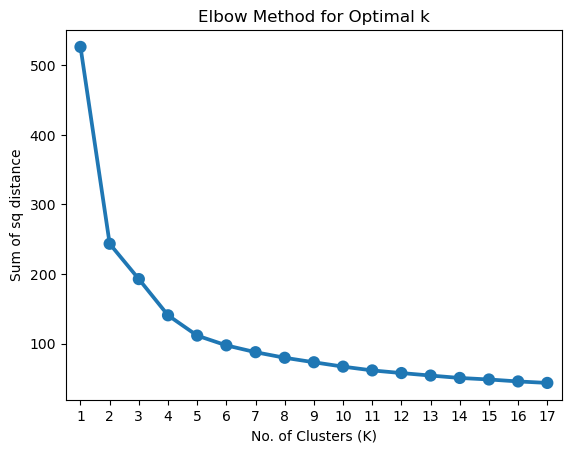

In [22]:
%matplotlib inline
from sklearn.cluster import KMeans


sum_of_sq_dist = {}
for k in range(1,18):
    km = KMeans(n_clusters = k, init = 'k-means++', max_iter = 1000)
    km = km.fit(scaled_data)
    sum_of_sq_dist[k] = km.inertia_
    
#plot the sum of square distances and cluster
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('No. of Clusters (K)')
plt.ylabel('Sum of sq distance')
plt.title('Elbow Method for Optimal k')
plt.show()
    


In [23]:
np.random.seed(42)

In [24]:
#Performing a k-means clustering
KMean_Clust  = KMeans(n_clusters = 6)
KMean_Clust.fit(scaled_data)

digi_RFMScore['Clusters'] = KMean_Clust.labels_
digi_RFMScore.head()

,Recency,Frequency,Monetary,Clusters
Client_ID,,,,
110061186,117,1,1500.0,3
110132366,391,1,1100.0,5
110227051,146,2,2366.0,3
110241842,1,72,172759.0,2
110243394,299,1,644.0,5


## Evaluating Perfomance using Silhoutte Score

In [25]:
# a silhouette score closer to 1 indicates a better clustering
# from sklearn.metrics import silhouette_score
# range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9]


# for n_clusters in range_n_clusters:
#     kmeans = KMeans(n_clusters=n_clusters)
#     kmeans.fit(scaled_data)
    
#     digi_RFMScore["cluster"] = kmeans.labels_
#    #digi_RFMScore["cluster"]
#     silhouette_avg = silhouette_score(scaled_data, digi_RFMScore["cluster"])
#     print("For n_clusters =", n_clusters,
#           "The average silhouette_score is :", silhouette_avg)

In [26]:
scaled_data.head()

,Recency,Frequency,Monetary
Client_ID,,,
110061186,0.710958,0.000000,0.469354
110132366,0.891162,0.000000,0.449458
110227051,0.744103,0.085661,0.498620
110241842,0.000000,0.528677,0.774020
110243394,0.851000,0.000000,0.415121


In [27]:
# import scipy.cluster.hierarchy as sch
# dendrogram = sch.dendrogram(sch.linkage(scaled_data, method = 'ward'))
# plt.title('Dendrogam', fontsize = 20)
# plt.xlabel('Customers')
# plt.ylabel('Euclidean Distance')
# plt.show()

In [28]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize = (20,10))
# ax = fig.add_subplot(111, projection = '3d')
# ax.scatter(digi_RFMScore.Recency[digi_RFMScore.Clusters == 0], digi_RFMScore.Frequency[digi_RFMScore.Clusters == 0], digi_RFMScore.Monetary[digi_RFMScore.Clusters == 0], c = 'blue', s =60)
# ax.scatter(digi_RFMScore.Recency[digi_RFMScore.Clusters == 1], digi_RFMScore.Frequency[digi_RFMScore.Clusters == 1], digi_RFMScore.Monetary[digi_RFMScore.Clusters == 1], c = 'red', s =60)
# ax.scatter(digi_RFMScore.Recency[digi_RFMScore.Clusters == 2], digi_RFMScore.Frequency[digi_RFMScore.Clusters == 2], digi_RFMScore.Monetary[digi_RFMScore.Clusters == 2], c = 'green', s =60)
# ax.scatter(digi_RFMScore.Recency[digi_RFMScore.Clusters == 3], digi_RFMScore.Frequency[digi_RFMScore.Clusters == 3], digi_RFMScore.Monetary[digi_RFMScore.Clusters == 3], c = 'purple', s =60)
# ax.scatter(digi_RFMScore.Recency[digi_RFMScore.Clusters == 4], digi_RFMScore.Frequency[digi_RFMScore.Clusters == 4], digi_RFMScore.Monetary[digi_RFMScore.Clusters == 4], c = 'orange', s =60)
# ax.scatter(digi_RFMScore.Recency[digi_RFMScore.Clusters == 5], digi_RFMScore.Frequency[digi_RFMScore.Clusters == 5], digi_RFMScore.Monetary[digi_RFMScore.Clusters == 5], c = 'yellow', s =60)
# ax.view_init(30,185)

# plt.xlabel('Recency')
# plt.ylabel('Frequency')
# ax.set_zlabel('Monetary')

# plt.show()

<Figure size 700x700 with 0 Axes>

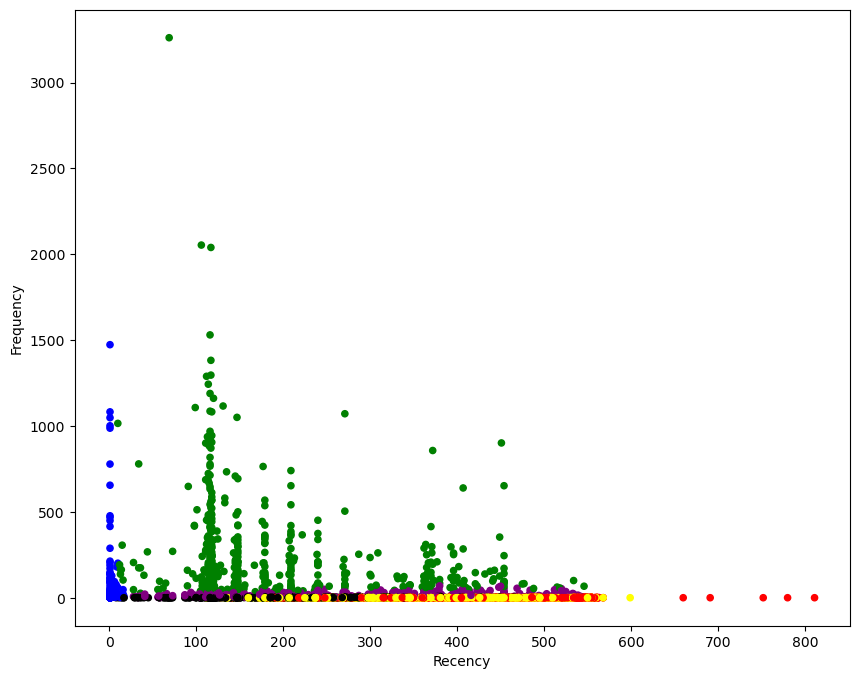

In [29]:
from matplotlib import pyplot as plt
plt.figure(figsize = (7,7))

colours = ['Red', 'Green', 'Blue', 'Black', 'Purple', 'Yellow']
digi_RFMScore['Color'] = digi_RFMScore['Clusters'].map(lambda p : colours [p])

ax = digi_RFMScore.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = digi_RFMScore['Color']
)

In [30]:
customer_clusters = digi_RFMScore.groupby(['Clusters'])['Recency'].aggregate('count').reset_index()
customer_clusters

,Clusters,Recency
0,0,3301
1,1,535
2,2,120
3,3,1356
4,4,768
5,5,3609


In [31]:
pivot_table = pd.pivot_table(
    digi_RFMScore, 
    index='Clusters', 
    values=['Recency', 'Frequency', 'Monetary'],
    aggfunc={'Recency': 'mean', 'Frequency': 'mean', 'Monetary': 'mean', 'Clusters': 'count'}
)

# Rename the columns to reflect the aggregation functions used
pivot_table = pivot_table.rename(columns={'Recency': 'Avg Recency', 'Frequency': 'Avg Frequency', 'Monetary': 'Avg Monetary', 'Clusters': 'Count'})

pivot_table.reset_index()

,Clusters,Count,Avg Frequency,Avg Monetary,Avg Recency
0,0,3301,1.248713,7646.457740,424.394123
1,1,535,253.801869,220572.706542,188.480374
2,2,120,109.041667,235755.558333,3.566667
3,3,1356,2.240413,2754.286136,216.562684
4,4,768,13.894531,46702.135417,282.649740
5,5,3609,1.090330,526.267387,382.526739


## 1. I was trying to figure the first  section of my Streamlit app ( Overview of the data)

In [32]:
# Data to use to create the interactive map 
# ignore the names that sound like they are not countyish. I will work on the master data and rename those rows.
sales = digi.groupby(['County'])['Amount'].aggregate('sum').reset_index().sort_values('Amount', ascending = False)
sales

,County,Amount
8,Kericho,23610606.0
1,Bungoma,18871130.0
3,Elgeyo Marakwet,18467632.0
25,Sirikwa Dairies,15064248.0
19,Nakuru,14331688.0
17,Meru,13509986.0
32,Uasin Gishu,11831474.0
18,Migori,10353692.0
2,Busia,10054001.0
29,Tharaka Nithi,8909200.0


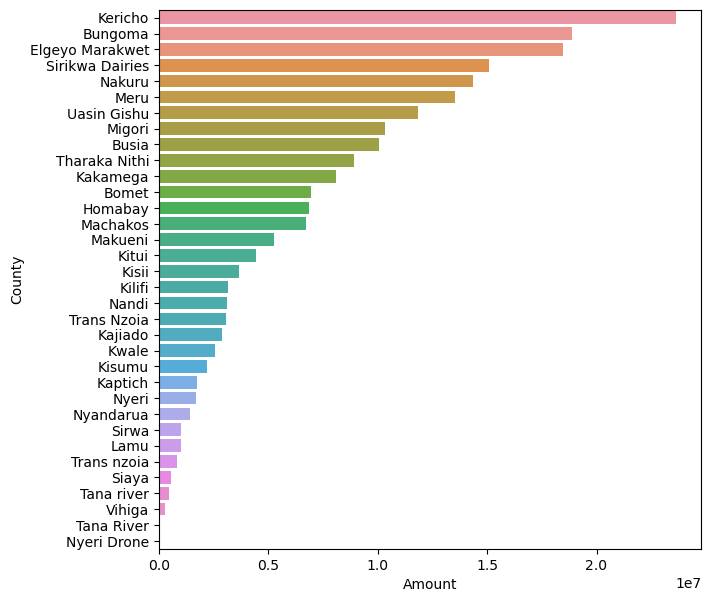

In [33]:
# I had given up on the map idea . 
# i wanted to see the view in a bar graph

fig = plt.figure(figsize= (7,7))

sns.barplot(data = sales, x = 'Amount', y ='County')
plt.show()

## Support needed
1. how to visualize the sales in a map
2. create a time series of the sales. i think a line graph can do also
3. The rest i will communicate later
